In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

# Demo 2 - GP

In [2]:
np.random.seed(12345)

n = 50
x = np.linspace(0, 1, n)
X = x.reshape(-1,1)

nugget = 0.75
sigma2_true = 4.0
l_true = 10

cov_func = sigma2_true * pm.gp.cov.ExpQuad(1, 1/l_true)
mean_func = pm.gp.mean.Zero()

y_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval(), 1
).flatten()

y = y_true + nugget * np.random.randn(n)

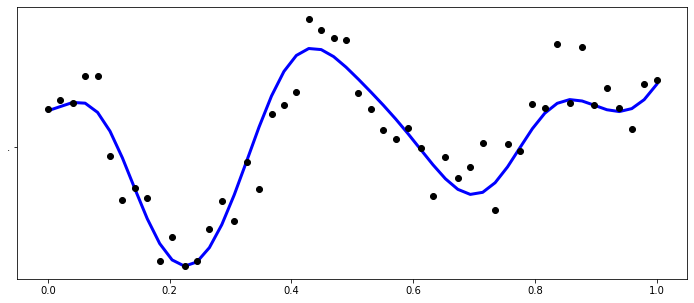

In [3]:
fig = plt.figure(figsize=(12, 5))
plt.plot(X, y_true, "-b", lw=3)
plt.plot(X, y, "ok", ".")
plt.show()

In [4]:
D = np.array([ np.abs(xi - x) for xi in x])
D0 = (D == 0).astype("double")

with pm.Model() as gp:
  nugget = pm.HalfCauchy("nugget", beta=5)
  sigma2 = pm.HalfCauchy("sigma2", beta=5)
  l      = pm.HalfCauchy("l",      beta=5)

  Sigma = D0 * nugget + sigma2 * np.exp(-0.5 * D**2 * l**2)
  
  y_ = pm.MvNormal("y", mu=np.zeros(n), cov=Sigma, observed=y)


In [5]:
with gp:
    #step = pm.Slice([nugget, sigma2, l])
    step = pm.NUTS([nugget, sigma2, l])
    trace = pm.sample(
        return_inferencedata = True,
        chains = 2,
        step = step
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [l, sigma2, nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


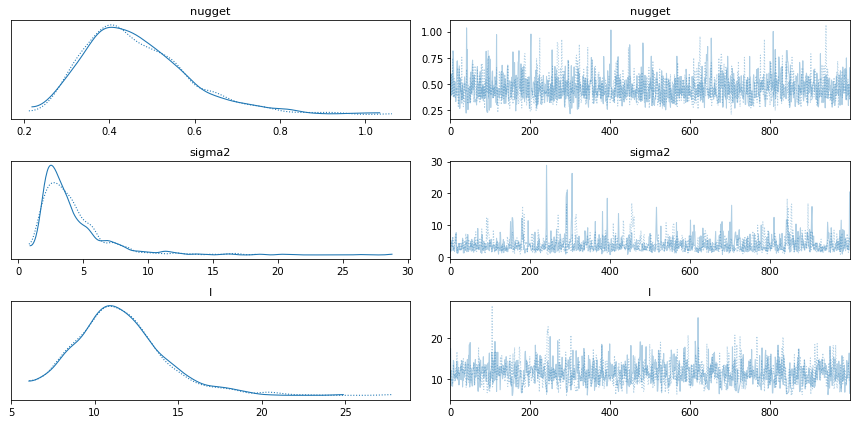

In [6]:
ax = az.plot_trace(trace)
plt.tight_layout()

In [7]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nugget,0.465,0.124,0.253,0.693,0.003,0.002,1565.0,1132.0,1.0
sigma2,4.125,2.594,1.147,8.384,0.090,0.063,1050.0,811.0,1.0
l,11.447,2.614,6.486,15.953,0.080,0.057,976.0,956.0,1.0


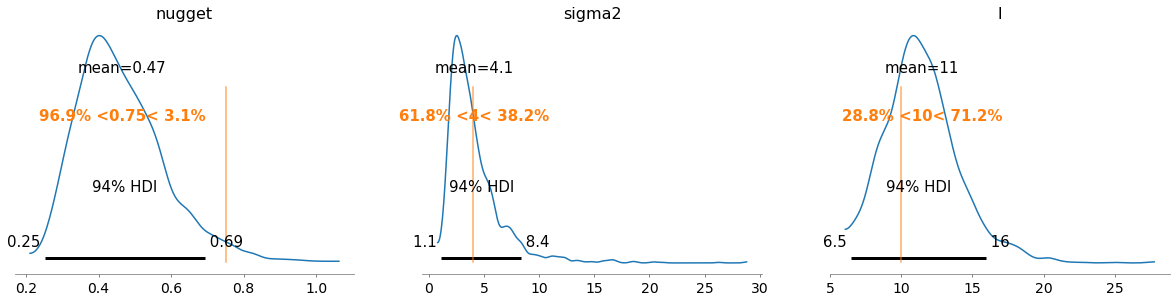

In [8]:
ax = az.plot_posterior(trace, ref_val=[0.75, 4, 10])

---

## Marginal GP tools

In [9]:
with pm.Model() as gp_marginal:
  nugget = pm.HalfCauchy("nugget", beta=5)
  sigma2 = pm.HalfCauchy("sigma2", beta=5)
  l      = pm.HalfCauchy("l",      beta=5)

  cov = sigma2 * pm.gp.cov.ExpQuad(input_dim=1, ls=1/l)
  gp = pm.gp.Marginal(cov_func=cov)

  y_ = gp.marginal_likelihood("y", X=X, y=y, noise=nugget)

In [10]:
with gp_marginal:
    step = pm.NUTS([nugget, sigma2, l])
    #step = pm.Slice([nugget, sigma2])
    trace = pm.sample(
        return_inferencedata = True,
        chains = 2,
        step = step
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [l, sigma2, nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [11]:
with gp_marginal:
    mp = pm.find_MAP(vars=[nugget,sigma2,l])

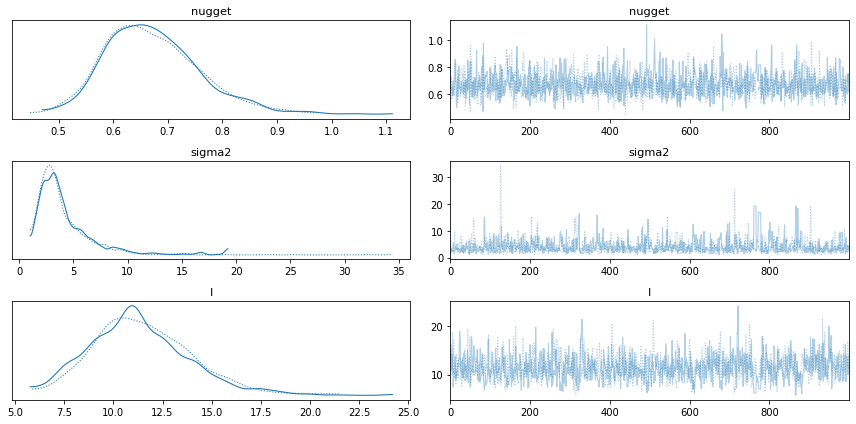

In [12]:
az.plot_trace(trace)
plt.tight_layout()

In [13]:
X_pred = np.linspace(0, 1, 1000)[:, None]

In [15]:
with gp_marginal:
    mp = pm.find_MAP(vars=[nugget,sigma2,l])

with gp_marginal:
    y_pred = gp.conditional("y_pred", X_pred)

with gp_marginal:
    pp = pm.sample_posterior_predictive([mp], var_names=["y_pred"], samples=500)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
lines = plt.plot(X_pred, pp["y_pred"].T, '-b', alpha=0.01)

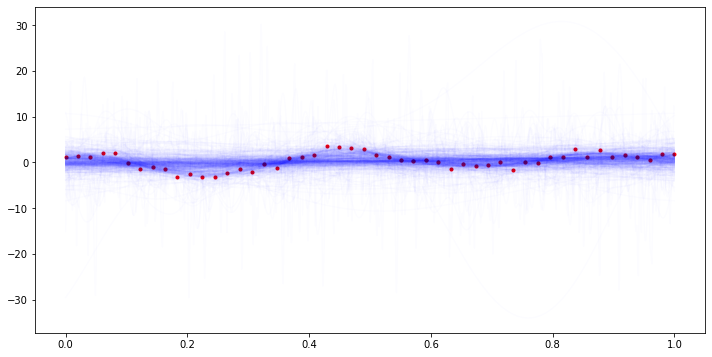

In [16]:
with gp_marginal:
    pp = pm.sample_posterior_predictive([trace], var_names=["y_pred"], samples=500)

plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
lines = plt.plot(X_pred, pp["y_pred"].T, '-b', alpha=0.01)

/opt/homebrew/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


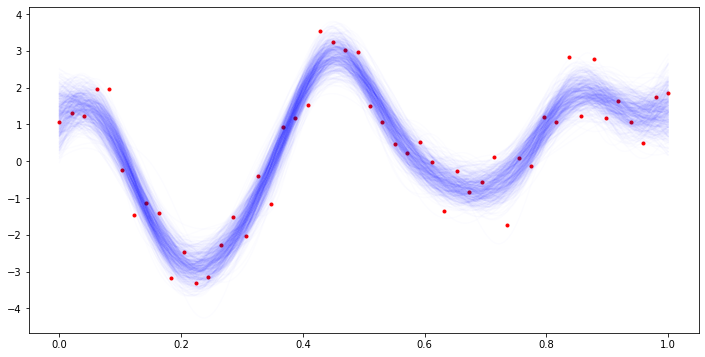

In [17]:
with gp_marginal:
    pp = pm.sample_posterior_predictive(trace, var_names=["y_pred"], samples=500)

plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
lines = plt.plot(X_pred, pp["y_pred"].T, '-b', alpha=0.01)

In [ ]:
res = []
for i in range(500):
    test  = {
        'nugget': trace.posterior["nugget"].values[0,i],
        'sigma2': trace.posterior["sigma2"].values[0,i],
        'l':      trace.posterior["l"].values[0,i]
    }
    with gp_marginal:
        pp = pm.sample_posterior_predictive([test], var_names=["y_pred"], samples=1, progressbar=False)
    
    res.append(pp["y_pred"])

res = np.array(res).reshape(500,-1)


In [ ]:

plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
lines = plt.plot(X_pred, res.T, '-b', alpha=0.01)